<a href="https://colab.research.google.com/github/DavideSoldani/sentiment-analysis-from-face-recognition/blob/master/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import dlib
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

In [0]:
#upload kaggle repository
!git clone https://github.com/muxspace/facial_expressions.git
#upload shape_predictor_68_face_landmarks.dat used in dlib
!git clone https://github.com/davisking/dlib-models.git
!bzip2 -d dlib-models/shape_predictor_68_face_landmarks.dat.bz2

In [0]:
dlib_model = "dlib-models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_model)

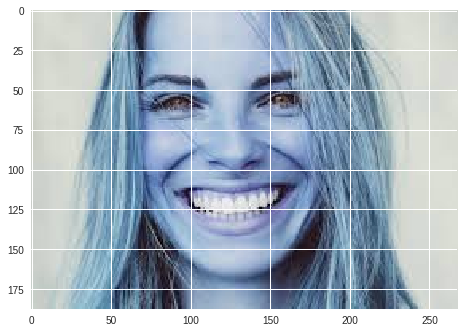

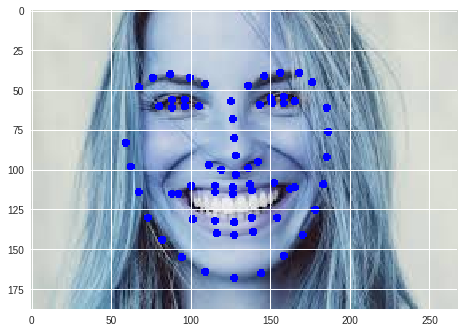

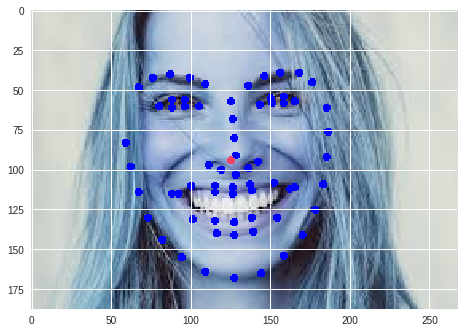

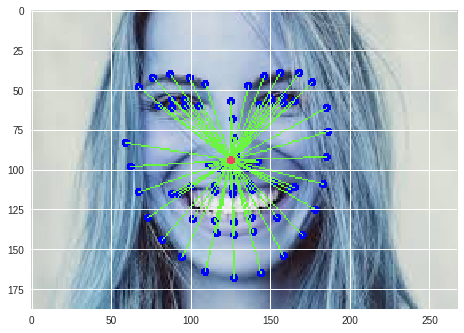

In [0]:
import cv2
from matplotlib import pyplot as plt

frame = cv2.imread ("sorriso_donna.jpg") 
plt.imshow(frame)
plt.show()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)
detections = detector(clahe_image, 1)
for k,d in enumerate(detections):
  shape = predictor(clahe_image, d)
  xlist = []
  ylist = []
  for i in range(1,68):
    xlist.append(float(shape.part(i).x))
    ylist.append(float(shape.part(i).y))
    cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
  plt.imshow(frame)
  plt.show()
  #find both coordinates (xmean, ymean) of centre of gravity
  xmean = np.mean(xlist)
  ymean = np.mean(ylist)
  meannp = np.asarray((ymean, xmean))
  cv2.circle(frame, (int(xmean), int(ymean)), 1, (244, 66, 101), thickness=2)
  plt.imshow(frame)
  plt.show()
  plt.imshow(frame)
  for x,y in zip(xlist,ylist):
    cv2.line(frame,(int(x),int(y)), (int(xmean), int(ymean)), (107, 244, 65), thickness=1 )
  cv2.circle(frame, (int(xmean), int(ymean)), 1, (244, 66, 101), thickness=2)
plt.imshow(frame)
plt.show()



 

**da qui inizia il vero codice** ------------------------------

In [0]:

#from csv file extract name of the images and respective labels, insert them into two arrays
import csv
def get_images_emotions(file_csv):
  images = []
  emotions = []
  max_images_happiness = 281
  max_images_neutral = 41
  max_images_surprise = 267
  with open(file_csv) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      emotion = row['emotion'].lower()
      if (emotion == 'disgust' or emotion == 'anger' or emotion == 'sadness' ):
        images.append(row['image'])
        emotions.append(emotion)
      if (emotion == 'happiness'):
        if (max_images_happiness > -1):
          images.append(row['image'])
          emotions.append(emotion)
          max_images_happiness = max_images_happiness - 1
      if (emotion == 'surprise'):
        if (max_images_surprise > -1):
          images.append(row['image'])
          emotions.append(emotion)
          max_images_surprise = max_images_surprise - 1
      if (emotion == 'neutral'):
        if (max_images_neutral > -1):
          images.append(row['image'])
          emotions.append(emotion)
          max_images_neutral = max_images_neutral - 1
  return images, emotions

In [0]:
#count number of emotion examples
import operator
def numb_emotions(file_csv):
  emotion2count = {}
  images, emotions = get_images_emotions(file_csv)
  for e in emotions:
    if e in emotion2count.keys():
      emotion2count[e] = emotion2count[e] + 1
    else:
      emotion2count[e] = 0
  sorted_emotion2count = sorted (emotion2count.items(), key = operator.itemgetter(1))
  return sorted_emotion2count

em2count = numb_emotions('facial_expressions/data/legend.csv')
print (em2count)

[('neutral', 41), ('disgust', 207), ('anger', 251), ('surprise', 267), ('sadness', 267), ('happiness', 281)]


In [0]:
EMOTIONS2 = ["anger", "disgust","happiness", "neutral", "sadness", "surprise"]
def pathimg_emotion_csv_file(images, emotions, emotion):
  img_label = []
  for img, em in zip (images, emotions):
    if (em == emotion):
      label = EMOTIONS2.index(em)
      img_path = 'facial_expressions/images/%s' %img
      img_label.append(tuple([img_path,label]))
  return img_label

In [0]:
#for each emotion, take the images in the dir "emotion" and associate it to the respective emotion
#emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
emotions = ["anger", "disgust","happiness", "neutral", "sadness", "surprise"]
file_csv = 'facial_expressions/data/legend.csv'

import glob
def pathimg_emotion(emotion):
  img_label = []
  label = EMOTIONS2.index(emotion) #convert the emotion into a number to use as label
  for img in glob.glob("sorted_set/%s/*.png" %emotion): #for each image in the folder named "emotion"
    img_label.append(tuple([img,label]))
  return img_label

import random
def get_imges_label():
  img_label_list = []
  for emotion in EMOTIONS2:
    img_label = pathimg_emotion(emotion)
    img_label_list = img_label_list + img_label
  random.shuffle(img_label_list)
  random.shuffle(img_label_list)
  return img_label_list

def get_path_images(emotion):
  path_images = []
  images, emotions = get_images_emotions(file_csv)
  path_images = pathimg_emotion(emotion) + pathimg_emotion_csv_file(images, emotions, emotion)
  print("dimensione del dataset: ",emotion, len(path_images) )
  return path_images

def get_imges_label2():
  img_label_list = []
  training = []
  test = []
  for emotion in EMOTIONS2:
    img_label_list = get_path_images(emotion)
    random.shuffle(img_label_list)
    training = training + img_label_list[:int(len(img_label_list)*0.8)]
    test = test + img_label_list[-int(len(img_label_list)*0.2):]
  img_label_list = training + test
  print("dim totale dataset: ", len(img_label_list))
  return img_label_list

def get_images_labels():
  images = []
  labels = []
  images_labels = get_imges_label2()
  for (img, em) in images_labels:
    images.append(img)
    labels.append(em)
  return images, labels


In [0]:
#take all images in the dataset
import glob
import random
def get_images(emotion):
  images = glob.glob("sorted_set/%s/*" %emotion)
  print(len(images), "%s" %emotion)
  random.shuffle(images)
  return images

In [0]:
#return list of landmarks for the image
dlib_model = "dlib-models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_model)
def get_landmarks(image):
  detections = detector(image, 1)
  for k,d in enumerate (detections):
    shape = predictor(image,d) #draw facial landmarks with the predictor class
    xlist = []
    ylist = []
    for i in range (1,68): #store X and Y coordinates in two lists
      xlist.append(float(shape.part(i).x))
      ylist.append(float(shape.part(i).y))
    #find both coordinates (xmean, ymean) of centre of gravity
    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    #calculate distance centre
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]
    landmarks_vectorised = []
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist): #store all landmarks in one list in the format x1,y1,distance from centre, angle ..
      landmarks_vectorised.append(w)
      landmarks_vectorised.append(z)
      meannp = np.asarray((ymean, xmean))
      coornp = np.asarray((z, w))
      dist = np.linalg.norm(coornp-meannp) #norm of a vector
      landmarks_vectorised.append(dist)
      landmarks_vectorised.append((math.atan2(y, x)*360) / (2*math.pi)) #return angle to the plane between x-positive axis and the point (x,y)
    #data['landmarks_vectorised'] = landmarks_vectorised
  if len(detections) < 1:
    #data['landmarks_vectorised'] = "error" 
    landmarks_vectorised = "error"
    return landmarks_vectorised
  else:
    return landmarks_vectorised
    


In [0]:
import numpy as np
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

#train a linear SVM classifier and evaluate
def classifier(data, labels):
  clf = svm.SVC(C = 1.0,kernel = 'linear')
  print ('classifier: ', clf )
  print ('preparing training and test set..')
  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20)
  npar_train_data = np.array(x_train)
  npar_train_labels = np.array (y_train)
  print("dimensione del training set: ", len(npar_train_data), "validation set: ", len (x_test))
  print ('training SVM classifier..')
  clf.fit(npar_train_data, y_train)
  print('getting accuracy..')
  npar_test_data = np.array(x_test)
  prediction = clf.score(npar_test_data, y_test)
  print("accuracy = ", prediction)
  print( classification_report(y_test, clf.predict(npar_test_data), target_names=EMOTIONS2) )
  
  print('getting accuracy with cross validation method..')
  cv_scores = cross_val_score(clf, npar_test_data, y_test, cv=5)
  print('cross validation scores: ',cv_scores)
  print('avarage scores: ',np.mean(cv_scores))  
  return clf

In [0]:
p = []
f = [1,2,3,4,5,6,7,8]
p + f[-int(len(f)*0.5):] + [1]

[5, 6, 7, 8, 1]

In [0]:
#obiettivo: processare il dataset in questo modo -> prendere dal csv la coppia immagine-emozione, processare l'immagine 
#ed estrarre le feature, momorizzare feature-label
#for each image, get the features (landmarks) and save them into two arrays features and label

def get_processed_set(images, emotions):
  processed_images = []
  labels = []
  num_face_errors = 0
  for img,emotion in zip(images,emotions):
    #img = "facial_expressions/images/%s" %img      
    #resized_image = resize(img)
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe_image = clahe.apply(gray)
    landmarks = get_landmarks(clahe_image)
    if landmarks == "error":
      #print ("no face detected on this one: ", img)
      num_face_errors = num_face_errors + 1
    else:
      processed_images.append(landmarks)
      labels.append(emotion)
  print("number no face detected ",num_face_errors)
  return processed_images, labels 
    

In [0]:
import time
start1 = time.time()
print("features extraction..")
images, lbls = get_images_labels()
features, labels = get_processed_set(images, lbls)
print(len(features), len (labels))
end1 = time.time()
slot_time1 = (end1-start1)/60
print("time for processing data: ", slot_time1)

features extraction..
dimensione del dataset:  anger 297
dimensione del dataset:  disgust 266
dimensione del dataset:  happiness 351
dimensione del dataset:  neutral 351
dimensione del dataset:  sadness 296
dimensione del dataset:  surprise 351
dim totale dataset:  1906
number no face detected  313
1593 1593
time for processing data:  3.760322380065918


In [0]:
start2 = time.time()
clf = classifier (features, labels)
end2 = time.time()
slot_time2 = (end2-start2)/60
print("time for training classifier (minutes): ", slot_time2)

classifier:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
preparing training and test set..
dimensione del training set:  1274 validation set:  319
training SVM classifier..
getting accuracy..
accuracy =  0.7115987460815048
              precision    recall  f1-score   support

       anger       0.60      0.69      0.64        54
     disgust       0.59      0.57      0.58        28
   happiness       0.83      0.81      0.82        70
     neutral       0.81      0.83      0.82        63
     sadness       0.47      0.46      0.47        37
    surprise       0.79      0.72      0.75        67

   micro avg       0.71      0.71      0.71       319
   macro avg       0.68      0.68      0.68       319
weighted avg       0.71      0.71      0.71       319

getting accuracy with cross validation 

In [0]:
EMOTIONS2 = ["anger", "disgust","happiness", "neutral", "sadness", "surprise"]

images_test = [ "sorriso_donna.jpg", "triste.jpg", "urlo.jpg"]
emotions = [ "happiness","sadness", "anger"]

for img, em in zip (images_test, emotions):
  image = cv2.imread(img)
  plt.imshow(image)
  plt.show() 
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  clahe_image = clahe.apply(gray_img)
  ftrs = np.array([get_landmarks(clahe_image)])
  print("classes: ",EMOTIONS2)
  print("classes_prob: ",clf.decision_function(ftrs))
  print("emotion_predicted: ", EMOTIONS2[clf.predict(ftrs)[0]], "emotion_expected: ", em)
  
  



NameError: ignored

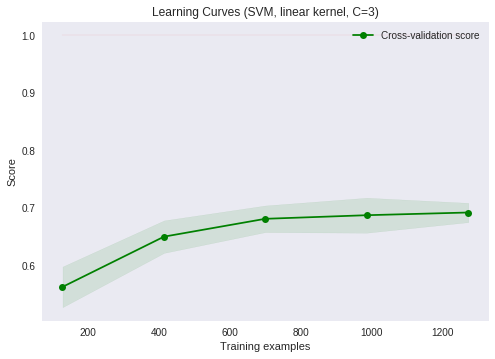

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
      plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color="g")
  #plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
           #label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label="Cross-validation score")

  plt.legend(loc="best")
  return plt

X, y = features, labels
c= 3
title = "Learning Curves (SVM, linear kernel, C=%s)" %c
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm.SVC(C = c,kernel = 'linear')
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)
plt.show()